# Case Study Report (Social Media Content - Sentiment Analysis)

## Import packages

In [1]:
#https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech
import numpy as np 
import pandas as pd 

from nltk import tokenize
import string
import re

import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.linear_model import LogisticRegression

# vectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
stop = stopwords.words('english')

from nltk.stem import PorterStemmer
porter = PorterStemmer()

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Print Stopword
stop 

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Load Dataset

In [3]:
pwd

'C:\\Users\\User\\My Jupyter Notebook'

In [4]:
df = pd.read_csv('.\\CaseStudy\\train.csv', index_col=0)
print(df)

       label                                              tweet
id                                                             
1          0   @user when a father is dysfunctional and is s...
2          0  @user @user thanks for #lyft credit i can't us...
3          0                                bihday your majesty
4          0  #model   i love u take with u all the time in ...
5          0             factsguide: society now    #motivation
...      ...                                                ...
31958      0  ate @user isz that youuu?ðððððð...
31959      0    to see nina turner on the airwaves trying to...
31960      0  listening to sad songs on a monday morning otw...
31961      1  @user #sikh #temple vandalised in in #calgary,...
31962      0                   thank you @user for you follow  

[31962 rows x 2 columns]


## Data Exploration / Exploratory data analysis(EDA)

In [5]:
df.columns

Index(['label', 'tweet'], dtype='object')

In [6]:
df["label"].unique()

array([0, 1], dtype=int64)

In [7]:
df["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

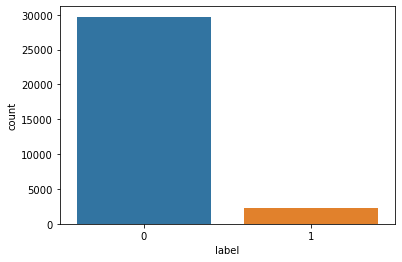

In [8]:
sns.countplot(x=df['label'])

In [9]:
positive = df[df['label']==0]
positive

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
...,...,...
31957,0,off fishing tomorrow @user carnt wait first ti...
31958,0,ate @user isz that youuu?ðððððð...
31959,0,to see nina turner on the airwaves trying to...


In [10]:
negative = df[df['label']==1]
negative

,label,tweet
id,,
14,1,@user #cnn calls #michigan middle school 'buil...
15,1,no comment! in #australia #opkillingbay #se...
18,1,retweet if you agree!
24,1,@user @user lumpy says i am a . prove it lumpy.
35,1,it's unbelievable that in the 21st century we'...
...,...,...
31935,1,lady banned from kentucky mall. @user #jcpenn...
31947,1,@user omfg i'm offended! i'm a mailbox and i'...
31948,1,@user @user you don't have the balls to hashta...


## Data Preprocessing

In [11]:
#Copy dataset for preprocessing
df_train = df.copy()

In [12]:
df_train.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


In [13]:
def preprocess(tweet):
    
    # convert to lowercase
    tweet = tweet.lower()

    #remove special characters
    #only remain characters from a-z and 0-9
    #remove the non-ASCII characters in a tweet
    tweet = re.sub('[^a-z0-9]+', ' ', tweet)

    # remove stop words 
    tweet = " ".join(w for w in tweet.split() if w not in stop)

    #stemming
    #tweet = " ".join(porter.stem(word) for word in tweet.split())

    #lemmatization
    tweet = " ".join(lemma.lemmatize(word) for word in tweet.split())
    
    return tweet

In [14]:
df_train['normalized_text'] = df_train.tweet.apply(preprocess)
tweets_df_clean = df['tweet'].apply(preprocess)

In [15]:
df_train.head()

,label,tweet,normalized_text
id,,,
1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drag kid dys...
2,0,@user @user thanks for #lyft credit i can't us...,user user thanks lyft credit use cause offer w...
3,0,bihday your majesty,bihday majesty
4,0,#model i love u take with u all the time in ...,model love u take u time ur
5,0,factsguide: society now #motivation,factsguide society motivation


In [16]:
print(tweets_df_clean[8]) # cleaned up version
print(df['tweet'][8]) # show the orignal version

next school year year exam think school exam hate imagine actorslife revolutionschool girl
the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams   #hate #imagine #actorslife #revolutionschool #girl


In [17]:
#balance data
from sklearn.utils import resample

#Separate majority and minority classes
df_major = df_train[df_train["label"] == 0]
df_minor = df_train[df_train["label"] == 1] #minority class

# Upsample minority class
df_minor_upsample = resample(df_minor, 
                             replace=True,     # sample with replacement
                             n_samples=len(df_major),    # to match average class
                             random_state=42) # reproducible results


# Combine majority class with upsampled minority class
dataset_resampled = pd.concat([df_major, df_minor_upsample])

# Display new class counts
print("Before")
print(df_train.label.value_counts())
print("After")
print(dataset_resampled.label.value_counts())

Before
0    29720
1     2242
Name: label, dtype: int64
After
0    29720
1    29720
Name: label, dtype: int64


In [18]:
dataset_resampled

,label,tweet,normalized_text
id,,,
1,0,@user when a father is dysfunctional and is s...,user father dysfunctional selfish drag kid dys...
2,0,@user @user thanks for #lyft credit i can't us...,user user thanks lyft credit use cause offer w...
3,0,bihday your majesty,bihday majesty
4,0,#model i love u take with u all the time in ...,model love u take u time ur
5,0,factsguide: society now #motivation,factsguide society motivation
...,...,...,...
24151,1,#msnbc #cnn #amjoy joe biden: 'i want to thank...,msnbc cnn amjoy joe biden want thank trump unm...
11116,1,@user indianapolis colts black cheerleader hug...,user indianapolis colt black cheerleader hug b...
3418,1,@user you might be a libtard if... #libtard #...,user might libtard libtard sjw liberal politics


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf=True)
X = vectorizer.fit_transform(dataset_resampled['normalized_text'])

In [20]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
y = dataset_resampled['label']

In [22]:
print (y.shape)
print (X.shape)

(59440,)
(59440, 36616)


In [23]:
print(X[0])

  (0, 27915)	0.29634154613949787
  (0, 10151)	0.46669343642887595
  (0, 18001)	0.2599677292857063
  (0, 9853)	0.415116454228614
  (0, 28687)	0.403877033412958
  (0, 10152)	0.48406315324355964
  (0, 11597)	0.22525375716836366
  (0, 34125)	0.07937873783036566


In [24]:
vectorizer.vocabulary_

{'user': 34125,
 'father': 11597,
 'dysfunctional': 10152,
 'selfish': 28687,
 'drag': 9853,
 'kid': 18001,
 'dysfunction': 10151,
 'run': 27915,
 'thanks': 32162,
 'lyft': 19849,
 'credit': 8014,
 'use': 34116,
 'cause': 6158,
 'offer': 23410,
 'wheelchair': 35326,
 'van': 34226,
 'pdx': 24484,
 'disapointed': 9343,
 'getthanked': 13368,
 'bihday': 4292,
 'majesty': 20043,
 'model': 21266,
 'love': 19530,
 'take': 31655,
 'time': 32695,
 'ur': 34078,
 'factsguide': 11385,
 'society': 29925,
 'motivation': 21534,
 'huge': 15669,
 'fan': 11486,
 'fare': 11518,
 'big': 4235,
 'talking': 31691,
 'leave': 18685,
 'chaos': 6379,
 'pay': 24432,
 'dispute': 9450,
 'get': 13340,
 'allshowandnogo': 1920,
 'camping': 5821,
 'tomorrow': 32902,
 'danny': 8505,
 'next': 22581,
 'school': 28404,
 'year': 36212,
 'exam': 11123,
 'think': 32494,
 'hate': 14744,
 'imagine': 16151,
 'actorslife': 1333,
 'revolutionschool': 27382,
 'girl': 13479,
 'land': 18455,
 'allin': 1888,
 'cavs': 6170,
 'champion'

In [25]:
len(vectorizer.vocabulary_)

36616

## Modelling

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
print("X train: ",X_train.shape)
print("y train: ",y_train.shape)
print("X test: ",X_test.shape)
print("X test: ",y_test.shape)

X train:  (41608, 36616)
y train:  (41608,)
X test:  (17832, 36616)
X test:  (17832,)


#### [Naive Bayes](https://medium.com/@chaudhurysrijani/what-is-so-naive-about-naive-bayes-and-how-does-it-deal-with-time-and-space-ea19826f5011)

### Multinomial Naive Bayes

In [28]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)
y_predict_test = NB_classifier.predict(X_test)

## Evaluation & Visualization

ROC Score:  0.9940297623890744


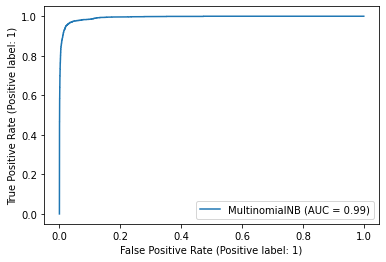

Average precision-recall score:  0.9111639314960639
F1-score:  0.949522215623819
Accuracy score:  0.9475661731718259
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      8886
           1       0.92      0.98      0.95      8946

    accuracy                           0.95     17832
   macro avg       0.95      0.95      0.95     17832
weighted avg       0.95      0.95      0.95     17832

[[8103  783]
 [ 152 8794]]


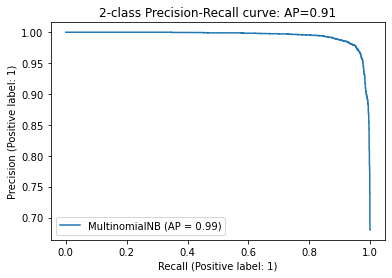

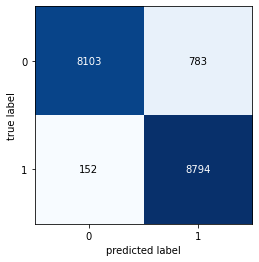

In [29]:
# ROC curve
print("ROC Score: ",roc_auc_score(y_test, NB_classifier.predict_proba(X_test)[:,1]))
metrics.plot_roc_curve(NB_classifier, X_test, y_test)
plt.show()  

# Precision-Recall Curve
average_precision = average_precision_score(y_test, y_predict_test)
print('Average precision-recall score: ',average_precision)
disp = plot_precision_recall_curve(NB_classifier, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# Confusion matrix
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_predict_test))

# Classification Report & F1-score & Accuracy Score
print('F1-score: ',f1_score(y_test, y_predict_test))
print('Accuracy score: ',accuracy_score(y_test, y_predict_test))
print(classification_report(y_test, y_predict_test))

print(confusion_matrix(y_test, y_predict_test))